# 1D heat conduction (layered medium)
[<!-- module-gdyn badge --><span class="module module-gdyn">Geodynamics</span>](module-gdyn) 
```{index} 1D steady state heat conduction
```

## 1D steady state heat equation

Consider a 1D model with two layers of different thermal conductivities - $k_U$ for layer $0 < y < a$ and $k_L$ for layer $a < y < b$. In either layer, no heat is generated.

Boundary conditions:
* temperature at $y=0$ is $T_s$
* temperature at $y=b$ is $T_m$

The governing ODE for each layer is:

$$k\frac{d^2T}{dy^2}=0.$$

### Analytical solution

Analytically, the ODE can be solved separately for upper and lower layer.

Upper layer ODE can be written as

$$k_U\frac{d^2 T_U}{dy^2}=0.$$

Integrating ODE once with respect to $y$ we obtain

$$\frac{dT_U}{dy}=A,$$

where $A$ is a constant of integration. Integrating once again, we get

$$T_U(y) = Ay+B.$$

Now, using boundary condition at $y=0$:

$$T_U(0)=A\times 0 + B =T_s\Rightarrow B = T_s,$$

$$T_U(y)=Ay+T_s.$$

Similarly for lower layer ODE is

$$k_L\frac{d^2 T_L}{dy^2}=0 \Rightarrow T_L(y)=Cy+D.$$

Using boundary condition at $y=b$, we get:

$$T_L(b)=Cb+D=T_m\Rightarrow D=T_m-Cb,$$

$$T_L(y)=T_m+C(y-b).$$

We have two unknown constants $A$ and $C$. For that, we need two more boundary conditions:

* temperature is continuous at the interface:

   $$T_L(a)=T_U(a)$$
   
* heat flux is continuous at the interface

The first condition yields:

$$Aa+T_s=T_m+C(a-b),$$

$$A=\frac{T_m-T_s+C(a-b)}{a}.$$

The solutions for both layers are then:

$$T_U =T_s+[T_m-T_s+C(a-b)]\frac{y}{a},$$

$$T_L = T_m+C(y-b).$$

The upwards heat flux into the interface from the lower layer is:

$$k_L\frac{dT_U(y)}{dy}\Big|_{y=a}=k_LC.$$

The upwards heat flux away from the interface into the upper layer is:

$$k_U\frac{dT_L(y)}{dy}\Big|_{y=a}=k_U[T_m-T_s+C(a-b)].$$

Equating these two heat fluxes we get:

$$k_LC=k_U[T_m-T_s+C(a-b)],$$

$$C=\frac{k_U(T_m-T_s)}{ak_L+(b-a)k_U}.$$

Therefore, the analytical solution yields:

$$T_U = T_s + (T_m-T_s) \Big[\frac{k_L}{ak_L +(b-a)k_U}\Big] y,$$

$$T_L = T_m + (T_m-T_s) \Big[\frac{k_U}{ak_L +(b-a)k_U}\Big] (y-b).$$

We can calculate and plot the analytical solution with the following code:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set boundary temperature
T_s = 0
T_m = 100

# Set y 
N = 51
L = 30
y = np.linspace(0,L,N)

# Set thermal conductivities
k_upper = 1
k_lower = 2

# Set layer thickness
a = y[int(N/2)]
b = y[-1]

# Calculate tempearture profile
T = np.zeros(N)

for i in range(len(T)):
    if y[i] <= a:
        T[i] = T_s+(T_m-T_s)*(k_lower/(a*k_lower+(b-a)*k_upper))*y[i]
    else:
        T[i] = T_m +(T_m-T_s)*(k_upper/(a*k_lower+(b-a)*k_upper))*(y[i]-b)

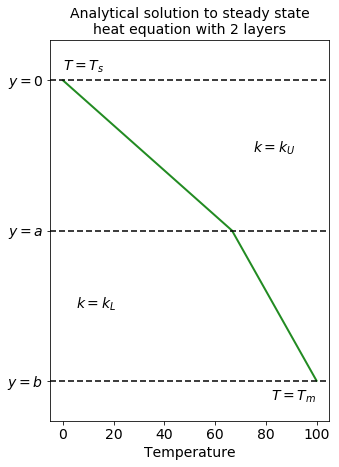

In [3]:
plt.figure(figsize=(5,7))

plt.plot(T, -y, color="forestgreen", lw=2)

plt.axhline(0, color="black", dashes=(4,2))
plt.axhline(-y[int(N/2)], color="black", dashes=(4,2))
plt.axhline(-y[-1], color="black", dashes=(4,2))

plt.xlabel("Temperature", fontsize=14)

plt.yticks([0, -y[int(N/2)], -y[-1]], ["$y=0$", "$y=a$", "$y=b$"], fontsize=14)
plt.xticks(fontsize=14)

plt.text(T[-1]*3/4., -y[int(N/4)], "$k=k_U$", fontsize=14)
plt.text(T[0]+5, -y[int(3*N/4)], "$k=k_L$", fontsize=14)
plt.text(T[0], -y[0]+1, "$T=T_s$", fontsize=14)
plt.text(T[-1], -y[-1]-2, "$T=T_m$", fontsize=14, ha='right')

plt.ylim(-y[-1]-4, -y[0]+4)
plt.xlim(T[0]-5, T[-1]+5)

plt.title("Analytical solution to steady state\nheat equation with 2 layers",
         fontsize=14)

plt.show()

### Numerical solution

In the previous section, we showed how to analytically solve 1D steady state heat equation for two layers with different thermal conductivities. Next, we will create a numerical solution.

#### Discretisation

The steady state ODE for heat equation in one dimension for material with uniform thermal conductivity states:

$$k\frac{d^2T}{dy^2}=0.$$

However, since our model has two layers of different conductivities, the equation becomes instead:

$$\frac{\partial}{\partial y}\Big(k\frac{\partial T}{\partial x}\Big)=0.$$

````{margin}
```{admonition} Thermal conductivity
:class: note
Thermal conductivity $k$ in this example is a piece-wise constant, therefore 

$$\frac{dk}{dx}$$

is a delta function. In the present case, our boundary conditions lead to the term

$$\frac{(k_{i+1}-k_{i-1})}{8k_i}(T_{i+1}-T_{i-1})$$

beging much smaller than 

$$\frac{1}{2}(T_{i+1}+T_{i-1})$$

term. However, if the changes in conductivity were of several orders of magnitude, discretising this problem with finite difference would be very difficult!

```
````

Using chain rule, we obtain:

$$\frac{\partial k}{\partial y}\frac{\partial T}{\partial y}+k\frac{\partial^2T}{\partial y^2} =0.$$

To discretise the equation, we will use finite difference methods. First derivative of temperature and thermal conductivity are described as

$$\left(\frac{\partial T}{\partial y} \right)\bigg\rvert_{y=y_i} \approx\frac{T_{i+1}-T_{i-1}}{2\Delta y}, \quad \left(\frac{\partial k}{\partial y}\right) \bigg\rvert_{y=y_i} \approx\frac{k_{i+1}-k_{i-1}}{2\Delta y}.$$

The second derivative of temperature is

$$\left(\frac{\partial^2 T}{\partial y^2}\right)\bigg\rvert_{y=y_i}\approx\frac{T_{i+1}-2T_{i}+T_{i-1}}{(\Delta y)^2}.$$

Now, we can substitude these into our equation:

$$\frac{k_{i+1}-k_{i-1}}{2\Delta y}\frac{T_{i+1}-T_{i-1}}{2\Delta y}+k_i\frac{T_{i+1}-2T_{i}+T_{i-1}}{(\Delta y)^2}=0\quad ||\cdot 4(\Delta y)^2,$$

$$(k_{i+1}-k_{i-1})(T_{i+1}-T_{i-1})+4k_i(T_{i+1}-2T_i+T_{i-1})=0,$$

$$8k_i T_i = (k_{i+1}-k_{i-1})(T_{i+1}-T_{i-1}) +4k_i(T_{i+1}+T_{i-1}).$$

And finally, we obtain the solution for temperature at $y_i$:

$$T_i = \frac{(k_{i+1}-k_{i-1})}{8k_i}(T_{i+1}-T_{i-1}) +\frac{1}{2}(T_{i+1}+T_{i-1}).$$

Code below shows the implementation and plot of obtained temperature profile:

In [4]:
# Set temperature arrays
T_old = np.zeros(N)
T_new = np.zeros(N)

# Set boundary conditions
T_old[0] = T_s
T_old[-1] = T_m

# Create y array
y = np.linspace(0,L,N)

# Create k array and 
# substitute correct conductivities
k = np.zeros(N)

for i in range(len(k)):
    if i <= int(N/2):
        k[i] = k_upper
    else:
        k[i] = k_lower

To obtain the temperature profile, we need to update $T_{old}$ multiple times to make sure our steady state solution converged. We will use RMS error to see how our solution converges as compared to the analytical solution:

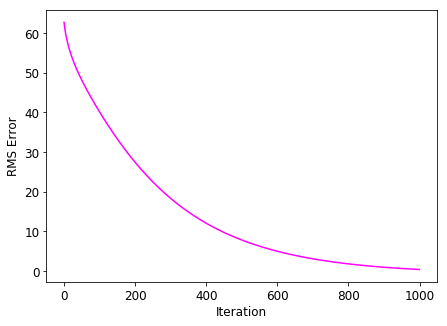

In [5]:
from sklearn.metrics import mean_squared_error

nf = 1000

rms = np.zeros(nf)

for it in range(nf):
    
    T_new = T_old

    for i in range(1,N-1):
        T_new[i] = (k[i+1]-k[i-1])/(8*k[i])*(T_old[i+1]-T_old[i-1])+1./2.*(T_old[i+1]+T_old[i-1])
        
    rms[it] = np.sqrt(mean_squared_error(T, T_new))
    
plt.figure(figsize=(7,5))
plt.plot(rms, color="magenta")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("RMS Error", fontsize=12)
plt.show()

Now we can plot the numerical solution:

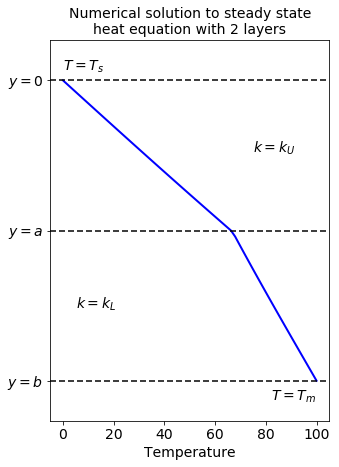

In [6]:
plt.figure(figsize=(5,7))

plt.plot(T_new, -y, color="blue", lw=2)

plt.axhline(0, color="black", dashes=(4,2))
plt.axhline(-y[int(N/2)], color="black", dashes=(4,2))
plt.axhline(-y[-1], color="black", dashes=(4,2))

plt.xlabel("Temperature", fontsize=14)

plt.yticks([0, -y[int(N/2)], -y[-1]], ["$y=0$", "$y=a$", "$y=b$"], fontsize=14)
plt.xticks(fontsize=14)

plt.text(T_old[-1]*3/4., -y[int(N/4)], "$k=k_U$", fontsize=14)
plt.text(T_old[0]+5, -y[int(3*N/4)], "$k=k_L$", fontsize=14)
plt.text(T_old[0], -y[0]+1, "$T=T_s$", fontsize=14)
plt.text(T_old[-1], -y[-1]-2, "$T=T_m$", fontsize=14, ha='right')

plt.ylim(-y[-1]-4, -y[0]+4)
plt.xlim(T_old[0]-5, T_old[-1]+5)

plt.title("Numerical solution to steady state\nheat equation with 2 layers",
         fontsize=14)

plt.show()

### Numerical vs. analytical solution

To compare the solutions, we will plot them and their difference at the same graph:

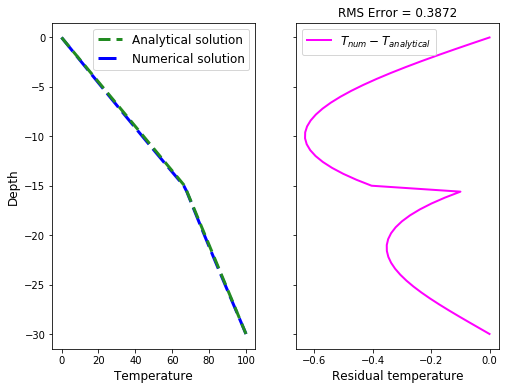

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8,6),
                        sharey=True)

ax1 = axes[0]
ax2 = axes[1]

ax1.plot(T, -y, color="forestgreen", dashes=(4,2),
         lw=3, label="Analytical solution", zorder=2)

ax1.plot(T_new, -y, color="blue", dashes=(6,2),
         lw=3, label="Numerical solution", zorder=1)

ax1.legend(loc="best", fontsize=12)

ax1.set_xlabel("Temperature", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)


ax2.plot(T_new-T, -y, color="magenta",
        lw=2, label="$T_{num}-T_{analytical}$")

ax2.set_xlabel("Residual temperature",
              fontsize=12)

ax2.legend(loc="best", fontsize=12)

# Create root mean scquared error
rms = np.sqrt(mean_squared_error(T, T_new))

ax2.set_title("RMS Error = %.4f" % rms)

plt.show()

As we can see on the graphs, the numerical solution is very close to the analytical solution.

### Three layers

The same numerical analysis can be applied to multiple layers with different thermal conductivites. Here we show an example of three layer model:

````{admonition} Setup the model
:class: dropdown, tip
```
N = 51
L = 30
T_old = np.zeros(N)
T_new = np.zeros(N)

T_old[0] = 0.
T_old[-1] = 100.

y = np.linspace(0,L,N)
k = np.zeros(N)

k1= 1
k2 = 2
k3 = 3
l1 = y[int(N/3)]
l2 = y[int(2*N/3)]
l3 = y[int(N)-1]

for i in range(len(k)):
    if y[i] <= l1:
        k[i] = k1
    elif y[i] <= l2:
        k[i] = k2
    else:
        k[i] = k3
```
````

````{admonition} Run the steady state solution
:class: dropdown, tip
```
nf = 1000
for it in range(nf):
    
    T_new = T_old

    for i in range(1,N-1):
        T_new[i] = (k[i+1]-k[i-1])/(8*k[i])*(T_old[i+1]-T_old[i-1])+1./2.*(T_old[i+1]+T_old[i-1])
        
```
````

````{admonition} Plot the results
:class: dropdown, tip
```
plt.figure(figsize=(5,7))

plt.plot(T_new, -y, color="blue", lw=2)

plt.axhline(0, color="black", dashes=(4,2))
plt.axhline(-y[int(N/3)], color="black", dashes=(4,2))
plt.axhline(-y[int(2*N/3)], color="black", dashes=(4,2))
plt.axhline(-y[-1], color="black", dashes=(4,2))

plt.xlabel("Temperature", fontsize=18)

plt.yticks([0, -y[int(N/3)],-y[int(2*N/3)], -y[-1]],
        ["$y=0$", "$y=a$", "$y=b$", "$y=c$"], fontsize=18)
plt.xticks(fontsize=18)

plt.text(T_old[-1]*3/4., -y[int(N/4)], "$k=k_1$", fontsize=18)
plt.text(T_old[0]+5, -y[int(N/2)], "$k=k_2$", fontsize=18)
plt.text(T_old[0]+5, -y[int(7*N/8)], "$k=k_3$", fontsize=18)
plt.text(T_old[0], -y[0]+1, "$T=T_s$", fontsize=18)
plt.text(T_old[-1], -y[-1]-2, "$T=T_m$", fontsize=18, ha='right')

plt.ylim(-y[-1]-4, -y[0]+4)
plt.xlim(T_old[0]-5, T_old[-1]+5)

plt.show()
```
````

In [8]:
N = 51
L = 30
T_old = np.zeros(N)
T_new = np.zeros(N)

T_old[0] = 0.
T_old[-1] = 100.

y = np.linspace(0,L,N)
k = np.zeros(N)

k1= 1
k2 = 2
k3 = 3
l1 = y[int(N/3)]
l2 = y[int(2*N/3)]
l3 = y[int(N)-1]

for i in range(len(k)):
    if y[i] <= l1:
        k[i] = k1
    elif y[i] <= l2:
        k[i] = k2
    else:
        k[i] = k3
        
nf = 1000
for it in range(nf):
    
    T_new = T_old

    for i in range(1,N-1):
        T_new[i] = (k[i+1]-k[i-1])/(8*k[i])*(T_old[i+1]-T_old[i-1])+1./2.*(T_old[i+1]+T_old[i-1])
        

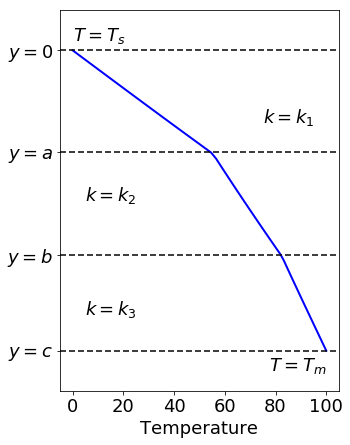

In [9]:
plt.figure(figsize=(5,7))

plt.plot(T_new, -y, color="blue", lw=2)

plt.axhline(0, color="black", dashes=(4,2))
plt.axhline(-y[int(N/3)], color="black", dashes=(4,2))
plt.axhline(-y[int(2*N/3)], color="black", dashes=(4,2))
plt.axhline(-y[-1], color="black", dashes=(4,2))

plt.xlabel("Temperature", fontsize=18)

plt.yticks([0, -y[int(N/3)],-y[int(2*N/3)], -y[-1]], 
           ["$y=0$", "$y=a$", "$y=b$", "$y=c$"], fontsize=18)
plt.xticks(fontsize=18)

plt.text(T_old[-1]*3/4., -y[int(N/4)], "$k=k_1$", fontsize=18)
plt.text(T_old[0]+5, -y[int(N/2)], "$k=k_2$", fontsize=18)
plt.text(T_old[0]+5, -y[int(7*N/8)], "$k=k_3$", fontsize=18)
plt.text(T_old[0], -y[0]+1, "$T=T_s$", fontsize=18)
plt.text(T_old[-1], -y[-1]-2, "$T=T_m$", fontsize=18, ha='right')

plt.ylim(-y[-1]-4, -y[0]+4)
plt.xlim(T_old[0]-5, T_old[-1]+5)

plt.show()

### Smooth k

So far, we created a piece wise function of thermal conductivity. In real life, it is more often the case that $k$ varies smoothly in space, especially at shallow depths. 

[Fisher _et al._ (2001)](https://www.sciencedirect.com/science/article/pii/S0012821X01003107) provides a relationship between depth and thermal conductivity for top $4\,m$ in the Alarcon basin based on field survey:

$$k = 0.70 + 0.0035\times \text{depth}.$$

According, to Figure 2 from the paper, we could take top temperature at $0^\circ C$ and bottom temperature between $0.5^\circ C$ and $2.5^\circ C$.

````{margin}
```{admonition} Try writing the code yourself!!
You will need to:
1. Make a list of bottom temperatures
2. Loop over the list to create temperature profiles
3. Plot the profiles
```
````
The numerical solution for these temperatures then looks:

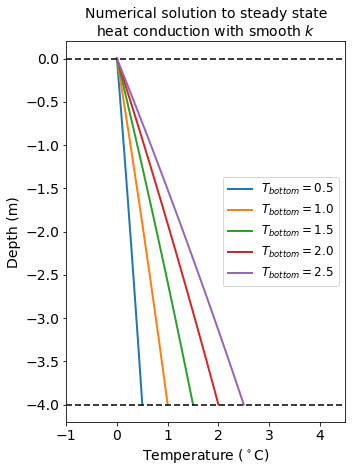

In [10]:
bottom_temp = [0.5, 1.0, 1.5, 2.0, 2.5]

plt.figure(figsize=(5,7))

for j in range(len(bottom_temp)):
    # Set boundary temperature
    T_s = 0
    T_m = bottom_temp[j]

    # Set y 
    N = 51
    L = 4
    y = np.linspace(0,L,N)

    # Set temperature arrays
    T_old = np.zeros(N)
    T_new = np.zeros(N)

    # Set boundary conditions
    T_old[0] = T_s
    T_old[-1] = T_m

    # Create y array
    y = np.linspace(0,L,N)

    # Create k array and 
    # substitute correct conductivities
    k = 0.7+y*0.035
    
    nf = 2000

    for it in range(nf):

        T_new = T_old

        for i in range(1,N-1):
            T_new[i] = (k[i+1]-k[i-1])/(8*k[i])*(T_old[i+1]-T_old[i-1])+1./2.*(T_old[i+1]+T_old[i-1])
            

    plt.plot(T_new, -y, lw=2, label="$T_{bottom} = %.1f$"% bottom_temp[j])

plt.axhline(0, color="black", dashes=(4,2))
plt.axhline(-y[-1], color="black", dashes=(4,2))

plt.xlabel("Temperature ($^\circ$C)", fontsize=14)
plt.ylabel("Depth (m)", fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(T_old[0]-1, T_old[-1]+2)

plt.title("Numerical solution to steady state\nheat conduction with smooth $k$",
         fontsize=14)

plt.legend(loc="best", fontsize="large")

plt.show()

## References
* Material used in this notebook was based on lecture content of Geodynamics module at Earth Science and Engineering Department at Imperial College London
* Fisher, A.T., Giambalvo, E., Sclater, J., Kastner, M., Ransom, B., Weinstein, Y. and Lonsdale, P., 2001. Heat flow, sediment and pore fluid chemistry, and hydrothermal circulation on the east flank of Alarcon Ridge, Gulf of California. _Earth and Planetary Science Letters_, 188(3-4), pp.521-534.